## Sample test simulation

This notebook contains the basic syntax required to run a chain. We set up a mock data object from a test sim, construct an emulator and likelihood object, and pass these to a sampler to run for a small number of steps.

Lace As 2.705816e-09 1.346831e-09 ns 1.015899 0.919232

Nyx As 3.427044e-09 9.201187e-10 ns 1.104939 0.8603856

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
import time
# our own modules
from lace.archive import gadget_archive
from lace.archive import nyx_archive
from lace.emulator import gp_emulator
from lace.emulator import nn_emulator
from cup1d.data import data_gadget
from cup1d.data import data_nyx
from cup1d.likelihood import lya_theory
from cup1d.likelihood import likelihood
from cup1d.likelihood import emcee_sampler

warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="growth"
# test_sim_label="mpg_0"
test_sim_label="mpg_central"
if type(test_sim_label)==int:
    drop_sim=str(test_sim_label)
    print('will drop sim number {} from emulator'.format(drop_sim))
else:
    drop_sim=None

In [3]:
# specify simulation suite and P1D mesurements
use_nyx=False
if use_nyx:
    sim_igm='nyx'
    emulator_label='Cabayol23_Nyx'
    archive=nyx_archive.NyxArchive(verbose=True)
    if drop_sim:
        drop_sim='nyx_'+drop_sim
else:
    sim_igm='mpg'
    emulator_label='Cabayol23'
    archive=gadget_archive.GadgetArchive(postproc='Cabayol23')
    if drop_sim:
        drop_sim='mpg_'+drop_sim

In [4]:
emulator = nn_emulator.NNEmulator(
    training_set='Cabayol23',
    emulator_label='Cabayol23',
    emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"],
    model_path='NNmodels/Cabayol23/Cabayol23.pt',
    train=False,
)

# emulator = nn_emulator.NNEmulator(
#     training_set='Nyx23_Oct2023',
#     emulator_label='Nyx_v0',
#     emu_params=["Delta2_p", "n_p", "mF", "sigT_Mpc", "gamma", "kF_Mpc"],
#     model_path='NNmodels/Nyx23_Oct2023/Nyx_v0.pt',
#     train=False,
# )

# setup emulator
# use_gp=False
# if use_gp:
#     if use_nyx:
#         raise ValueError('can not use GP with Nyx emulator')
#     emulator=gp_emulator.GPEmulator(archive=archive,emulator_label=emulator_label,drop_sim=drop_sim)
# else:
#     emulator=nn_emulator.NNEmulator(archive=archive,emulator_label=emulator_label,drop_sim=drop_sim)

Selected training set from Cabayol23
Select emulator in Cabayol23
Neural network emulating the optimal P1D of Gadget simulations fitting coefficients to a 5th degree polynomial. It goes to scales of 4Mpc^{-1} and z<=4.5. The parameters passed to the emulator will be overwritten to match these ones
Model loaded. No training needed


In [5]:
# setup mock data from sim 
z_max=4.5
data_label='Chabanier2019'
if use_nyx:
    data=data_nyx.Nyx_P1D(archive=archive,sim_label=str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=emulator.kmax_Mpc,
                                polyfit_ndeg=emulator.ndeg)
else:
    data=data_gadget.Gadget_P1D(archive=archive,sim_label=str(test_sim_label),
                                z_max=z_max,data_cov_label=data_label,
                                polyfit_kmax_Mpc=emulator.kmax_Mpc,
                                polyfit_ndeg=emulator.ndeg)

### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
# stick to primordial power-law parameters here
free_param_names=["As","ns"]
# specify the number of free parameters per IGM function (default=2, but it would take forever here)
n_igm=0
for i in range(n_igm):
    for par in ["tau","sigT_kms","gamma","kF"]:
        free_param_names.append('ln_{}_{}'.format(par,i))
free_param_names

['As', 'ns']

In [ ]:
# cosmo_fid

In [7]:
theory = lya_theory.Theory(
    zs=data.z,
    emulator=emulator,
    free_param_names=free_param_names,
    sim_igm=sim_igm,
    emu_type='nn'
)

In [8]:
# option to include/remove a Gaussian prior (in unit cube)
prior_Gauss_rms=None
# option to include/ignore emulator covariance (it might bias the results)
emu_cov_factor=0
like=likelihood.Likelihood(data=data, theory=theory,
                           free_param_names=free_param_names,
                           prior_Gauss_rms=prior_Gauss_rms,
                           emu_cov_factor=emu_cov_factor)

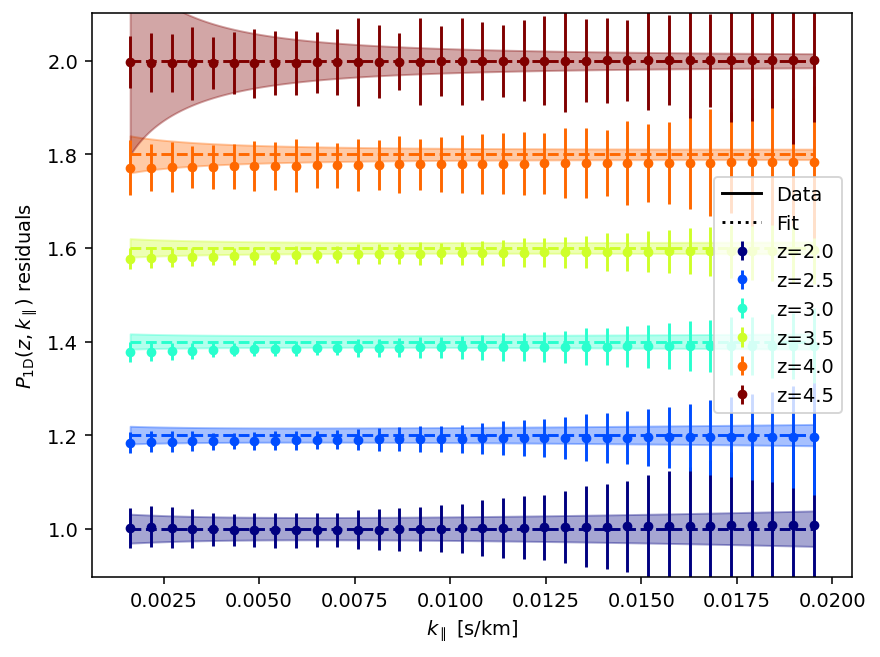

In [9]:
like.plot_p1d(residuals=True,plot_every_iz=2)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [10]:
import os

In [11]:
# Set up sampler
rootdir = os.path.dirname(os.environ["LACE_REPO"]) + "/data/cup1d/sampler/"
sampler = emcee_sampler.EmceeSampler(like=like,
                                     progress=True,
                                     rootdir=rootdir)

Created directory: /home/jchaves/Proyectos/projects/lya/data/cup1d/sampler//chain_13
setup with 80 walkers


In [12]:
for p in like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

As 2.1e-09 7.4e-10 4.11e-09
ns 0.965 0.68 1.32


In [13]:
n_burn_in=75
n_steps=500
start = time.time()
emcee_out = sampler.run_sampler(n_burn_in, n_steps, parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|█████████████████████████████████████████| 575/575 [01:02<00:00,  9.21it/s]

-130.23503282846949
Sampling took 62.5 seconds


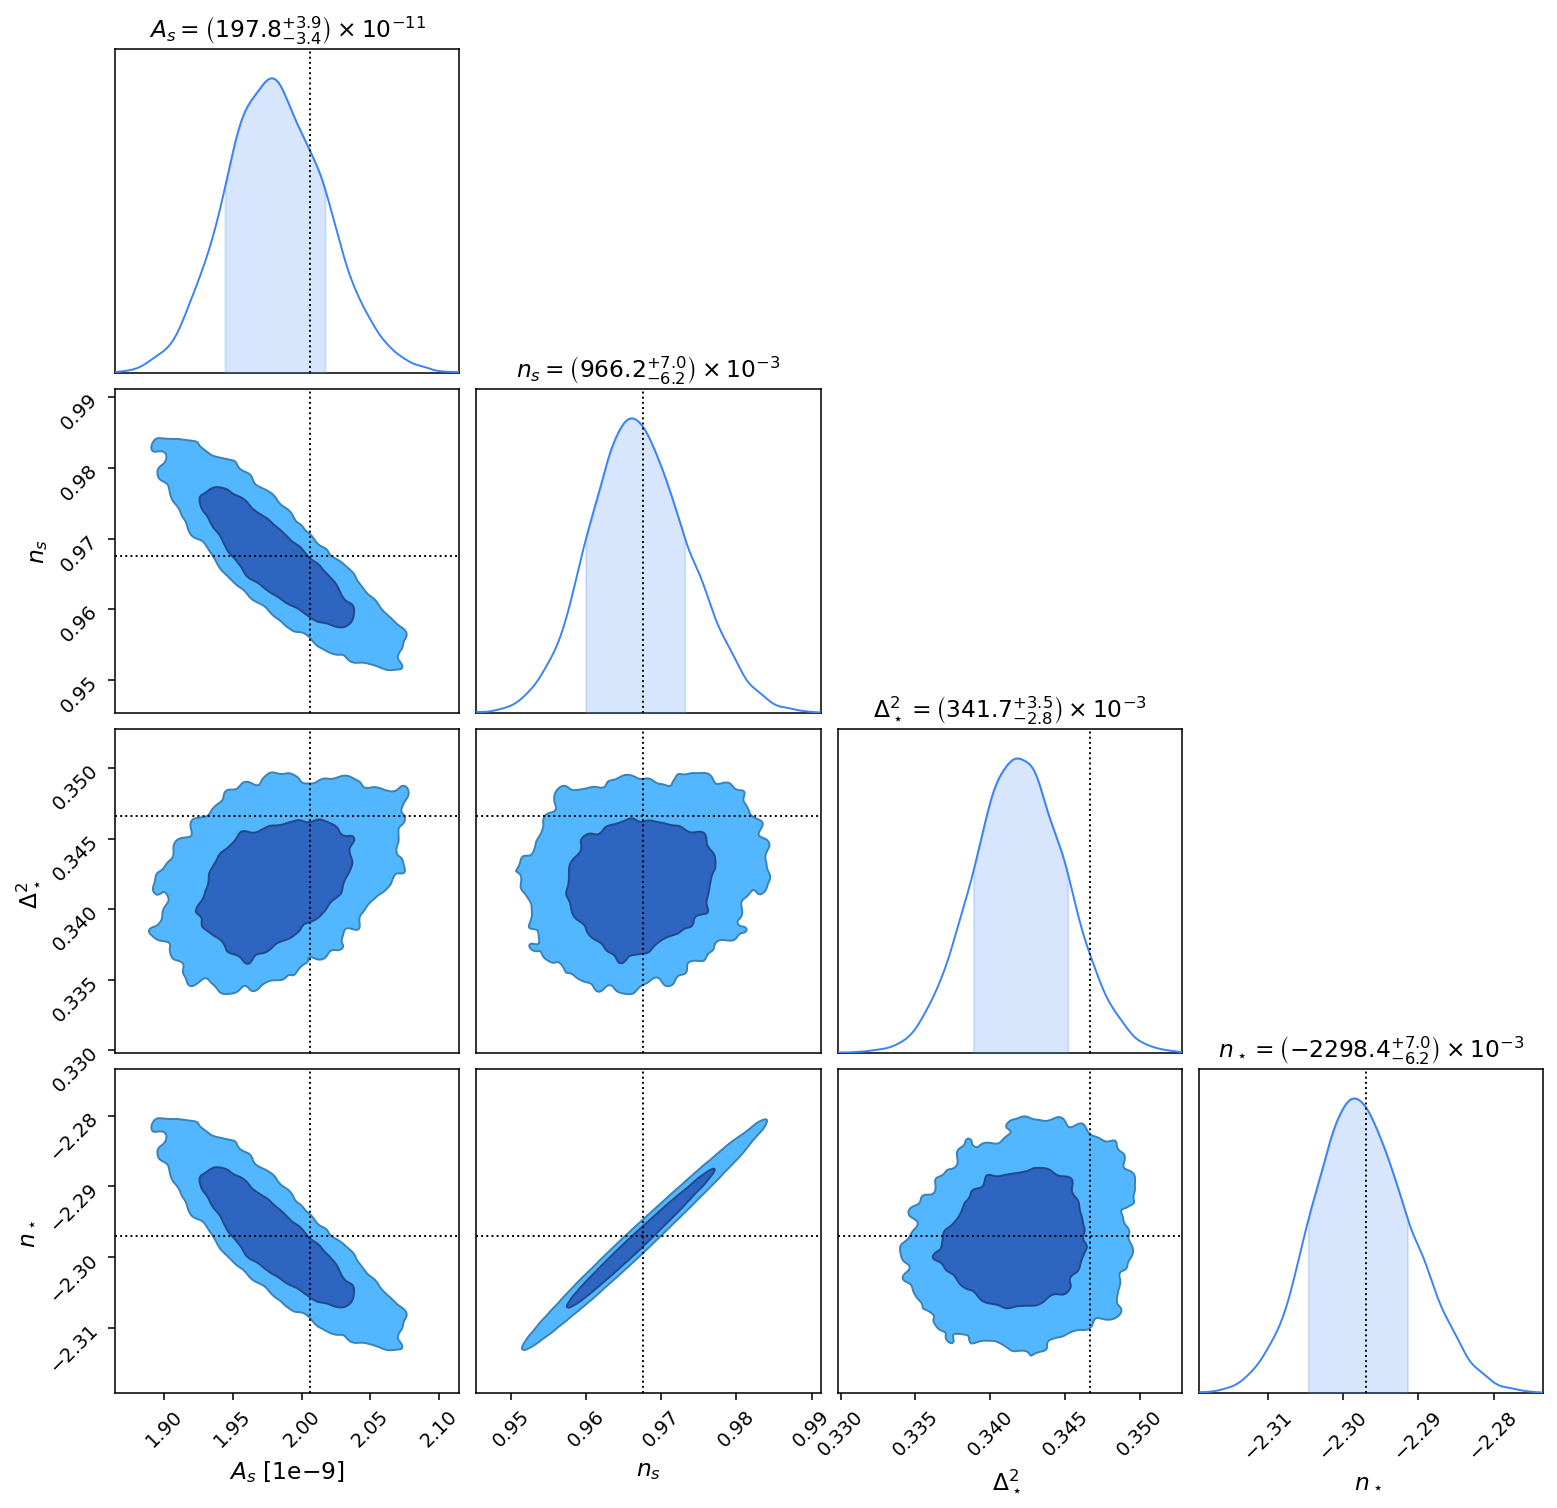

In [14]:
sampler.write_chain_to_file(plots=False)

In [ ]:
sampler.plot_corner()

In [17]:
# listpar = ['$\\Delta^2_\\star$','$n_\\star$']
listpar = ['$\\Delta^2_\\star$','$n_\\star$', 
           "$\mathrm{ln}\,\\tau_0$",
           "$\mathrm{ln}\,\\sigma^T_0$",
           "$\mathrm{ln}\,\\gamma_0$", 
           "$\mathrm{ln}\,k^F_0$", 
          ]
# listpar = ['$\\Delta^2_\\star$','$n_\\star$', 
#            "$\mathrm{ln}\,\\tau_0$", "$\mathrm{ln}\,\\tau_1$",
#            "$\mathrm{ln}\,\\sigma^T_0$", "$\mathrm{ln}\,\\sigma^T_1$",
#            "$\mathrm{ln}\,\\gamma_0$", "$\mathrm{ln}\,\\gamma_1$",
#            "$\mathrm{ln}\,k^F_0$", "$\mathrm{ln}\,k^F_1$",
#           ]

In [81]:
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

In [129]:
def plot_corner(
    self, plot_params=None, delta_lnprob_cut=None, usetex=True, serif=True
):
    """Make corner plot in ChainConsumer
    - plot_params: Pass a list of parameters to plot (in LaTeX form),
                or leave as None to
                plot all (including derived)
    - if delta_lnprob_cut is set, keep only high-prob points"""

    params_plot, strings_plot = self.get_all_params(
        delta_lnprob_cut=delta_lnprob_cut
    )
    dict_pd = {}
    noplot = np.array(strings_plot)[-4:]
    for ii, par in enumerate(strings_plot):
        if par not in noplot:
            dict_pd[par] = params_plot[:, ii]
    pd_data = pd.DataFrame(data=dict_pd)

    c = ChainConsumer()
    chain = Chain(samples=pd_data, name="a")
    c.add_chain(chain)
    summary = c.analysis.get_summary()["a"]
    cov = chain.get_covariance()
    corr = chain.get_correlation()
    c.add_truth(
        Truth(location=sampler.truth, line_style=":", color="black")
    )
    fig = c.plotter.plot(figsize=(12, 12))

    # c.add_chain(params_plot, parameters=strings_plot, name="Chains")

    # c.configure(
    #     diagonal_tick_labels=False,
    #     tick_font_size=10,
    #     label_font_size=25,
    #     max_ticks=4,
    #     usetex=usetex,
    #     serif=serif,
    # )

    ## Decide which parameters to plot
    # if plot_params == None:
    #     ## Plot all parameters
    #     params_to_plot = strings_plot
    # else:
    #     ## Plot params passed as argument
    #     params_to_plot = plot_params

    # fig = c.plotter.plot(
    #     figsize=(12, 12), parameters=params_to_plot, truth=self.truth
    # )

    if self.save_directory is not None:
        fig.savefig(self.save_directory + "/corner.pdf")
    else:
        fig.show()

    return

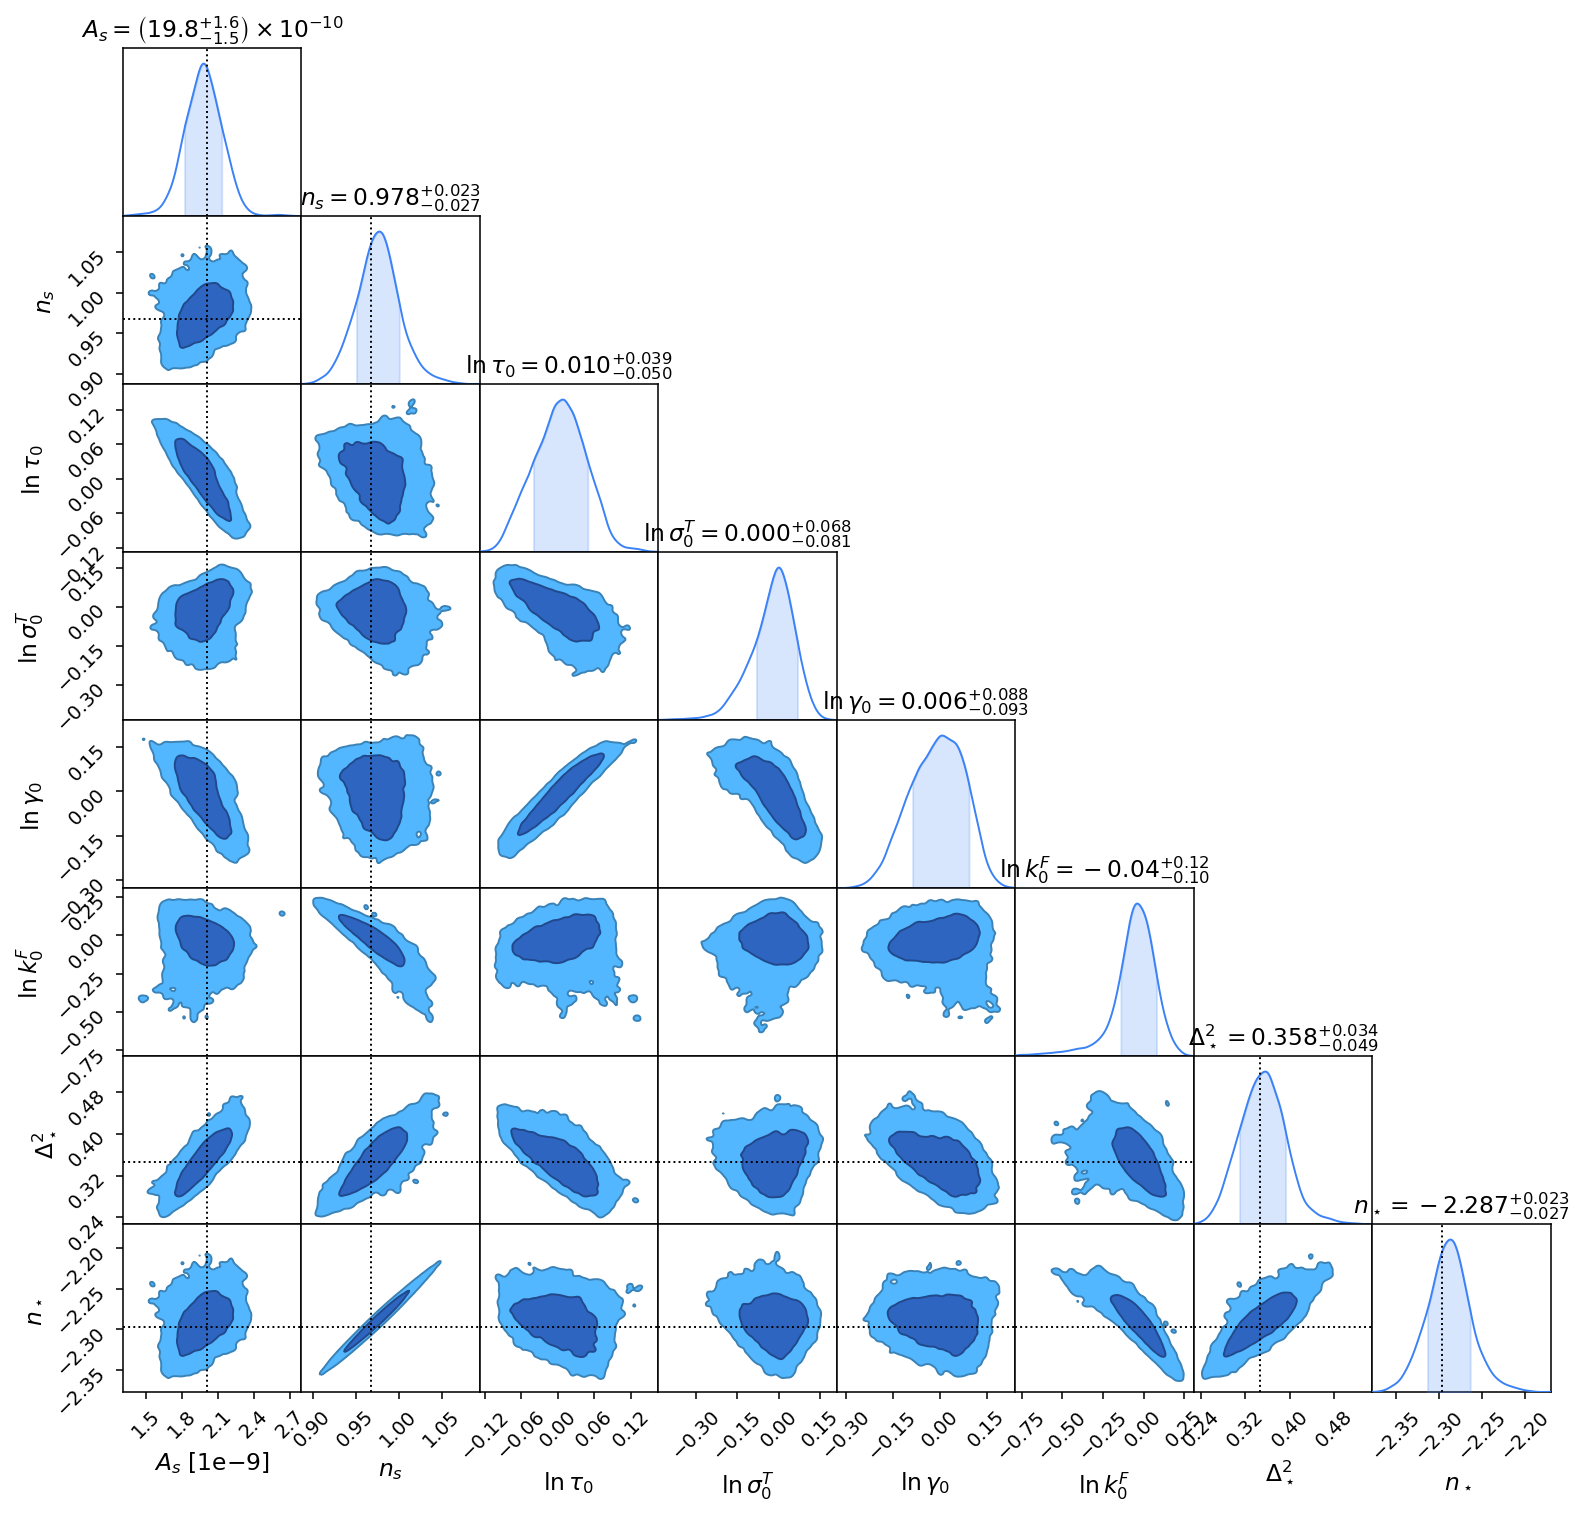

In [130]:
plot_corner(sampler)

In [131]:
sampler.save_directory

'/home/jchaves/Proyectos/projects/lya/data/cup1d/sampler//chain_11'

In [73]:
params_plot, strings_plot = sampler.get_all_params()
dict_pd = {}
noplot = np.array(strings_plot)[-4:]
for ii, par in enumerate(strings_plot):
    if(par not in noplot):
        dict_pd[par] = params_plot[:, ii]
pd_data = pd.DataFrame(data=dict_pd)

In [74]:
c = ChainConsumer()
chain = Chain(samples=pd_data, name="a")
c.add_chain(chain)
summary = c.analysis.get_summary()['a']
cov = chain.get_covariance()
corr = chain.get_correlation()
c.add_truth(Truth(location=sampler.truth, line_style=":", color="black"))
fig = c.plotter.plot(figsize=(12, 12))

In [191]:
lnprob = emcee_out.get_log_prob(
        flat=False, discard=250
    ) 
lnprob.shape

(550, 400)

In [31]:
nsteps_all = lnprob.shape[0]

In [179]:
sampler.burnin_nsteps = 250

In [46]:
sampler.chain = emcee_sampler.get_chain(flat=True, discard=sampler.burnin_nsteps)
sampler.lnprob = emcee_sampler.get_log_prob(flat=True, discard=sampler.burnin_nsteps)
sampler.blobs = emcee_sampler.get_blobs(flat=True, discard=sampler.burnin_nsteps)

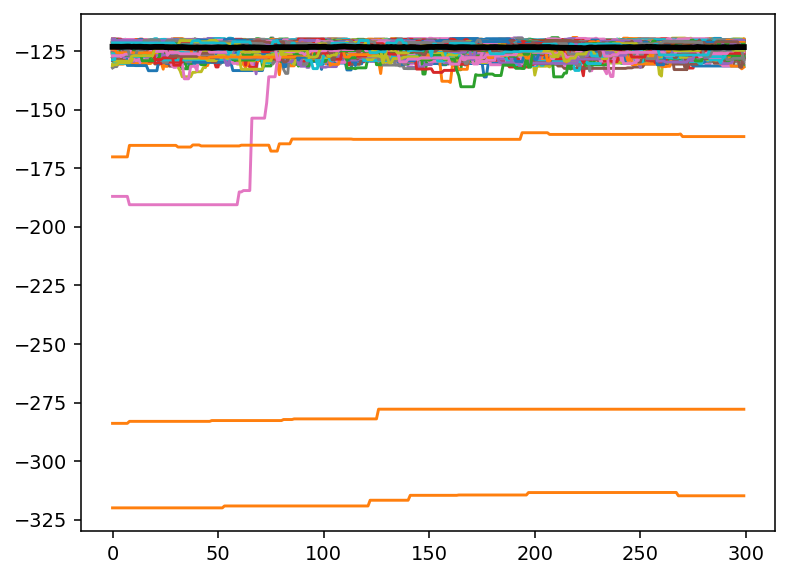

In [196]:
mask = np.arange(nsteps_all - sampler.burnin_nsteps) + sampler.burnin_nsteps
for ii in range(sampler.nwalkers):
    plt.plot(lnprob[mask, ii])
plt.plot(np.median(lnprob, axis=1)[mask], color='k', lw=3)
# plt.ylim(-100, -160)

In [122]:
lnprob = emcee_out.get_log_prob(
        flat=False, discard=sampler.burnin_nsteps
    ) 
lnprob.shape

(300, 240)

In [121]:
sampler.burnin_nsteps = 250

In [125]:
chain = emcee_out.get_chain(
        flat=False, discard=sampler.burnin_nsteps
    )
chain = chain[:, mask, :].reshape(-1, chain.shape[-1])
chain.shape

(69600, 6)

In [115]:
from corner import corner

In [141]:
lnprob[:,mask].reshape(-1)[:, None].shape

(69600, 1)

In [160]:
sampler.blobs = emcee_out.get_blobs(flat=False, discard=sampler.burnin_nsteps)
sampler.blobs.shape

(300, 240)

In [161]:
sampler.chain = chain
sampler.lnprob = lnprob[:,mask].reshape(-1)
sampler.blobs = sampler.blobs[:,mask].reshape(-1)

### compute max, select peak around max

In [154]:
chain[np.argmax(lnprob[:,0])]

array([0.65213181, 0.49813559, 0.29653186, 0.32849492, 0.15421122,
       0.42079766])

In [149]:
plot2 = np.concatenate([chain, lnprob[:, mask].reshape(-1)[:, None]], axis=1)

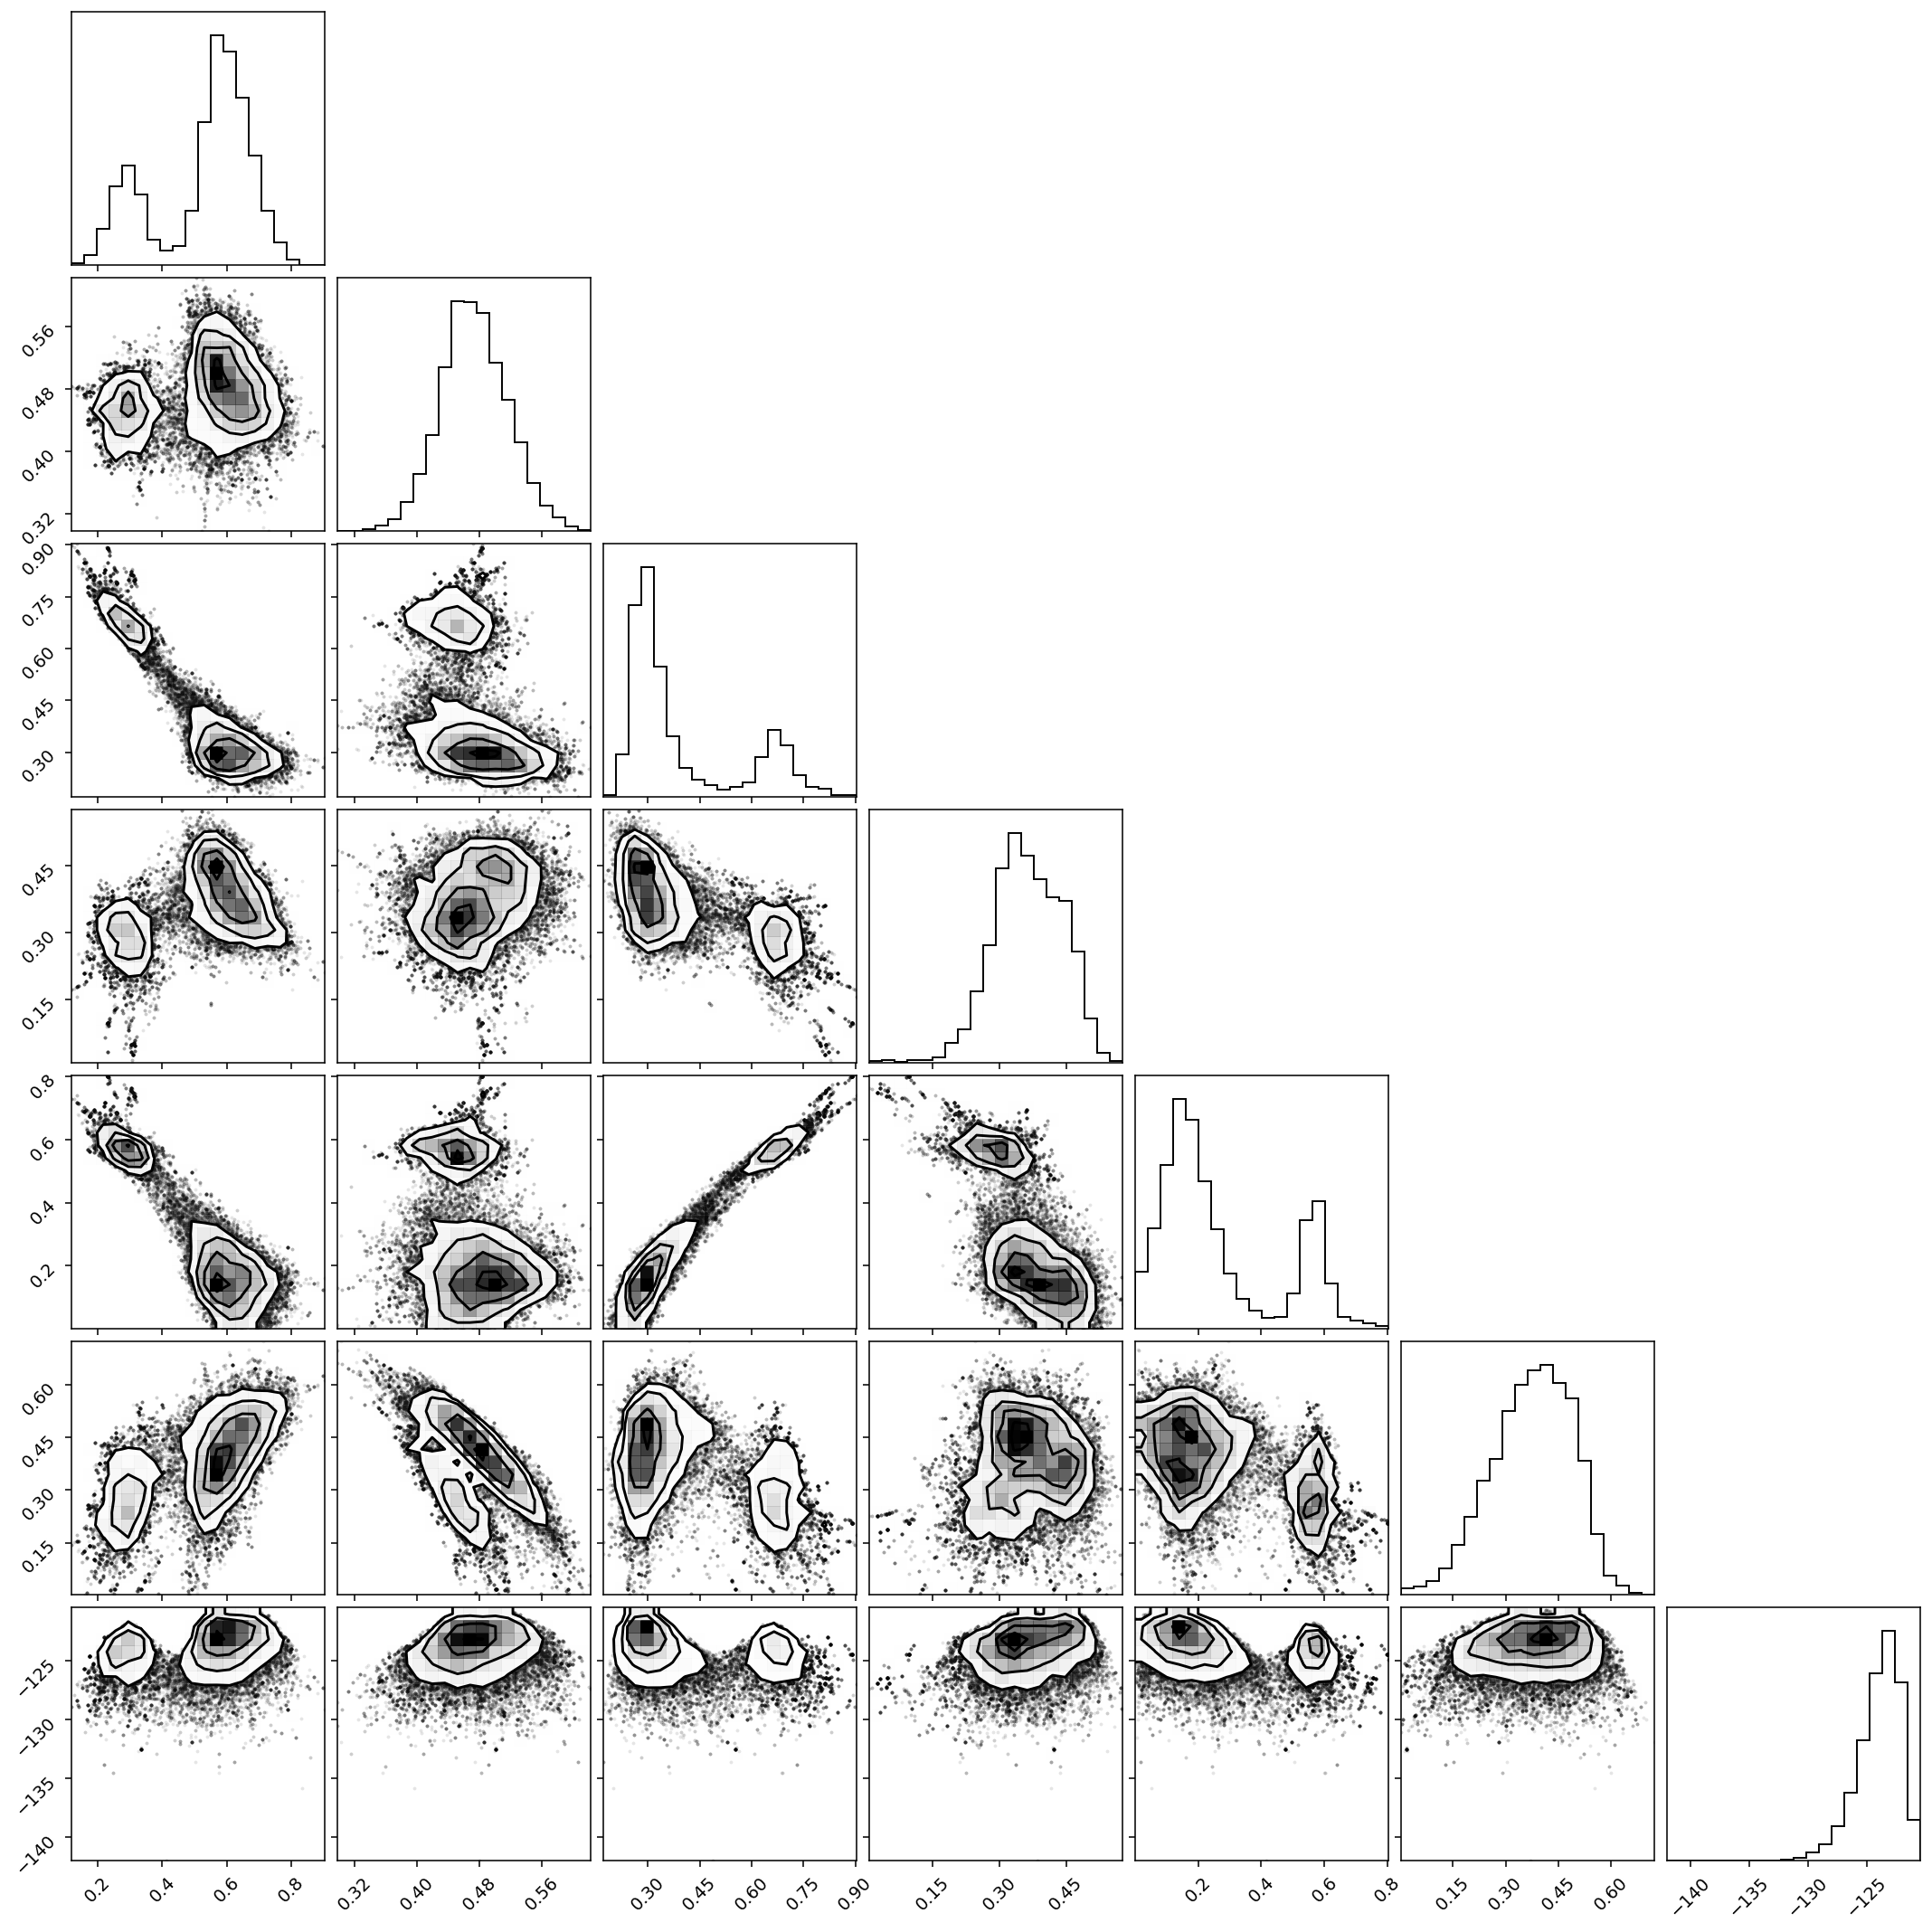

In [150]:
corner(plot2);

In [193]:
mask, _ = purge_chains(lnprob)
mask.shape

-133.34063896368548


(390,)

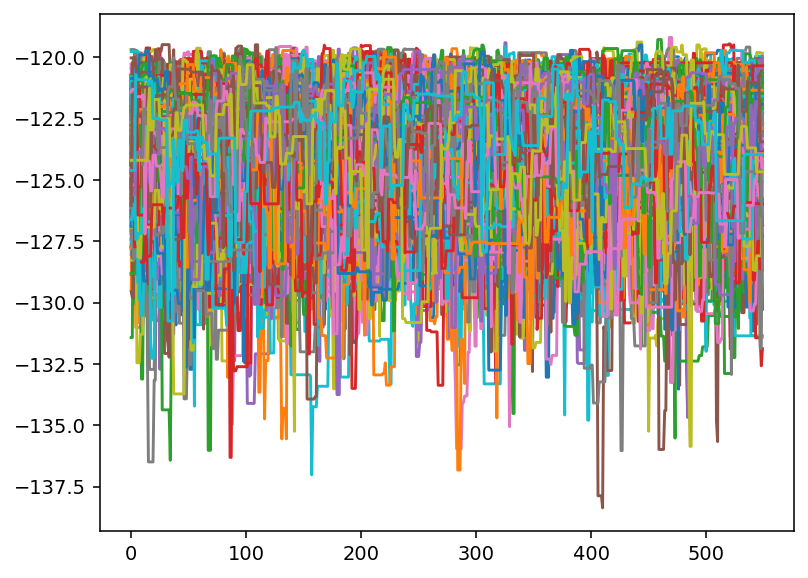

In [194]:
for ii in range(sampler.nwalkers):
    if(ii in mask):
        plt.plot(lnprob[:, ii])
#     else:
#         plt.plot(lnprob[:, ii])
# plt.plot(np.median(lnprob[:, mask], axis=1), color='k', lw=3)

In [ ]:
0 IGM, 75 burn in
1 IGM, 250 burn in
2 IGM, 250 burn in